In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load datasets
methods = {
    'Original': '../data/raw/uc_diagnostic_tests.csv',
    'MICE': '../data/processed/uc_diagnostic_tests_mice.csv',
    'KNN': '../data/processed/uc_diagnostic_tests_knn.csv',
    'SoftImpute': '../data/processed/uc_diagnostic_tests_softimpute.csv',
    'GAIN': '../data/processed/uc_diagnostic_tests_gain.csv',
    'PMM': '../data/processed/uc_diagnostic_tests_pmm.csv'
}

dfs = {}
for name, path in methods.items():
    try:
        # Original data uses ',' as decimal separator
        if name == 'Original':
            dfs[name] = pd.read_csv(path, decimal=',')
        else:
            # Imputed data was saved by pandas with '.' (default)
            dfs[name] = pd.read_csv(path, decimal='.')
            
        print(f"Loaded {name}: {dfs[name].shape}")
    except Exception as e:
        print(f"Error loading {name} at {path}: {e}")

# numeric columns only for analysis
numeric_cols = dfs['Original'].select_dtypes(include=[np.number]).columns
print(f"Numeric columns: {len(numeric_cols)}")

Loaded Original: (252, 56)
Loaded MICE: (252, 56)
Loaded KNN: (252, 56)
Loaded SoftImpute: (252, 56)
Loaded GAIN: (252, 56)
Loaded PMM: (252, 56)
Numeric columns: 56


## Distribution Analysis
We will visualize the distribution of a few randomly selected features (or features with high missingness in original) to see how imputation affects them.

Top missing columns: ['TRANSFERYNA', ' Morfologia RDW-SD', ' Morfologia PDW', 'Morfologia PCT']


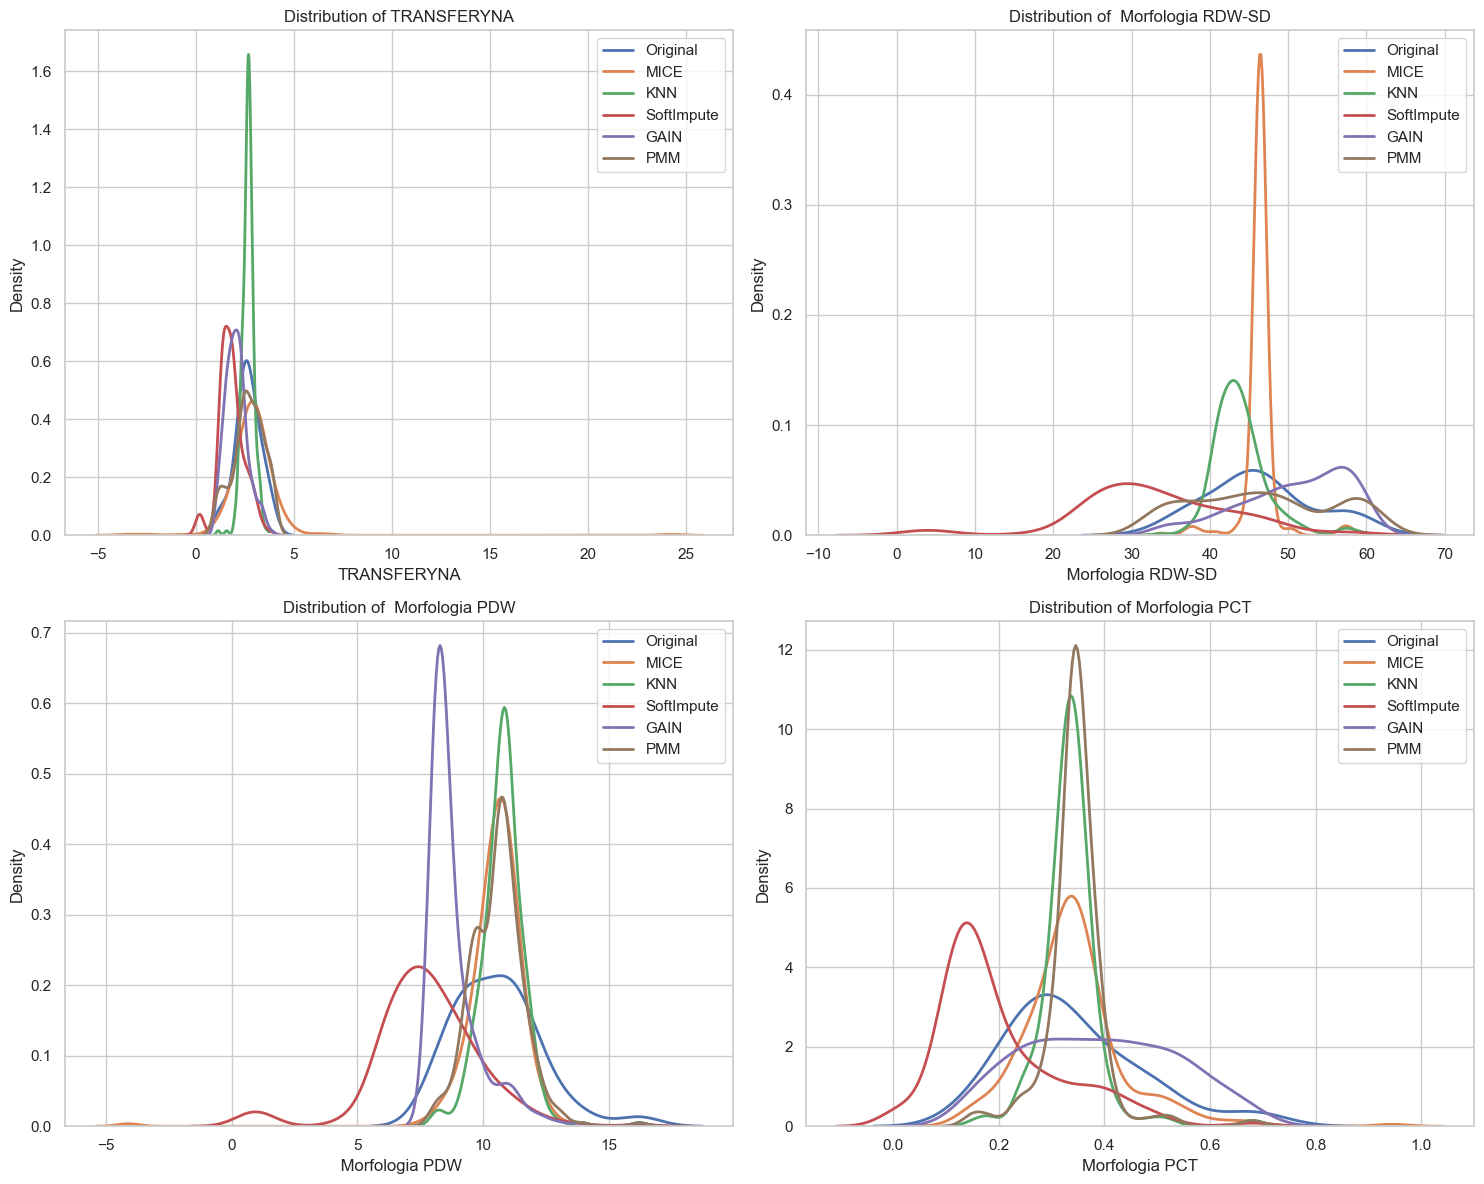

In [3]:
# Identify columns with most missing values in original data
missing_counts = dfs['Original'][numeric_cols].isna().sum().sort_values(ascending=False)
top_missing_cols = missing_counts.head(4).index.tolist()

print(f"Top missing columns: {top_missing_cols}")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(top_missing_cols):
    ax = axes[i]
    for name, df in dfs.items():
        # Ensure data is numeric and drop NaNs for plotting
        # this handles potential string formatting issues
        if col in df.columns:
            series = pd.to_numeric(df[col], errors='coerce').dropna()
            
            if len(series) > 1: # KDE needs at least 2 points (and variance)
                try:
                    sns.kdeplot(x=series, label=name, ax=ax, linewidth=2)
                except Exception as e:
                    print(f"Could not plot {name} for {col}: {e}")
            
    ax.set_title(f'Distribution of {col}')
    ax.legend()

plt.tight_layout()
plt.show()

## Correlation Analysis
Compare the correlation matrices to see if relationships between variables are preserved.

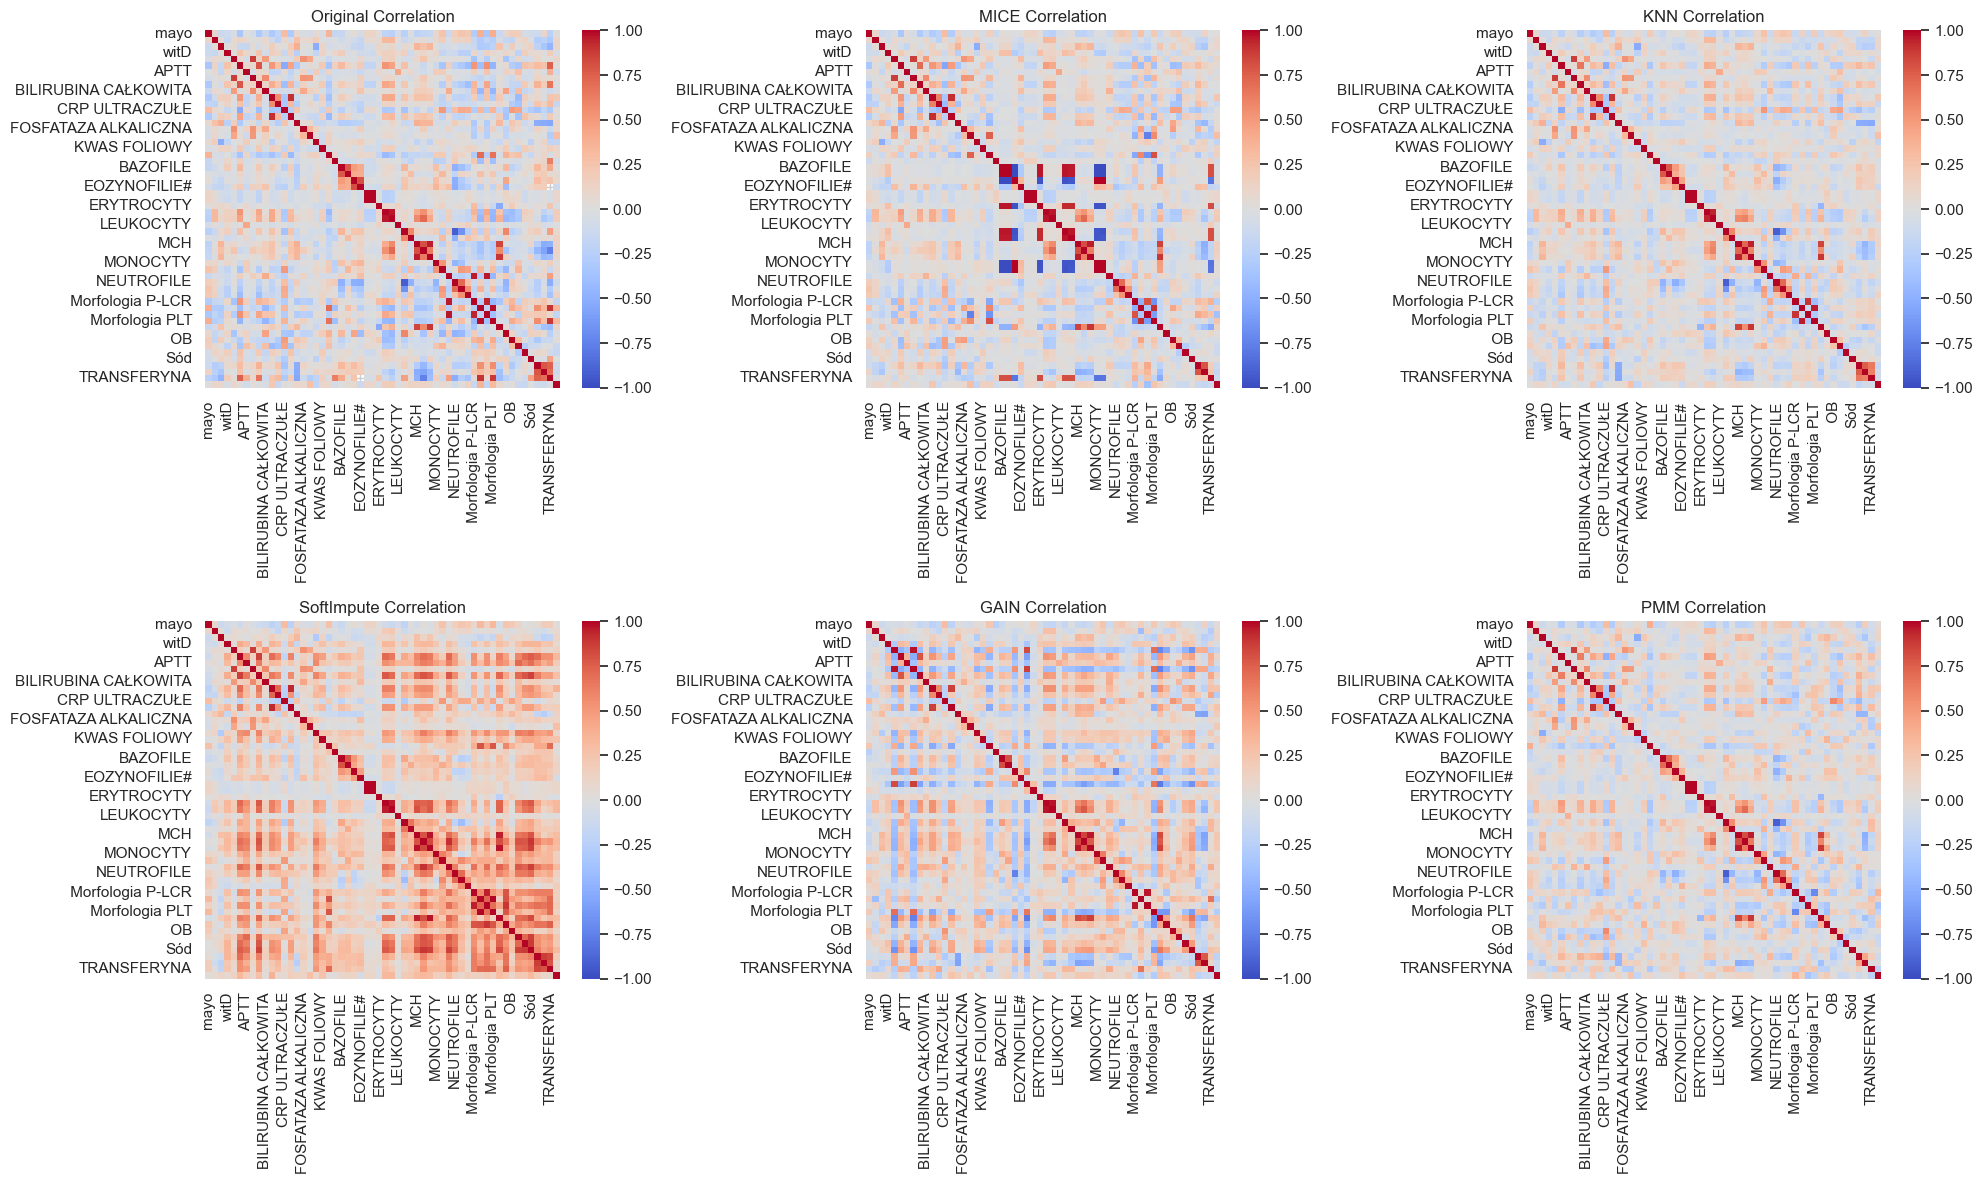

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (name, df) in enumerate(dfs.items()):
    if i >= len(axes): break
    ax = axes[i]
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_title(f'{name} Correlation')

# Remove empty subplots if any
for j in range(len(dfs), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## PCA Analysis
Project data into 2D space to visualize global structure differences.

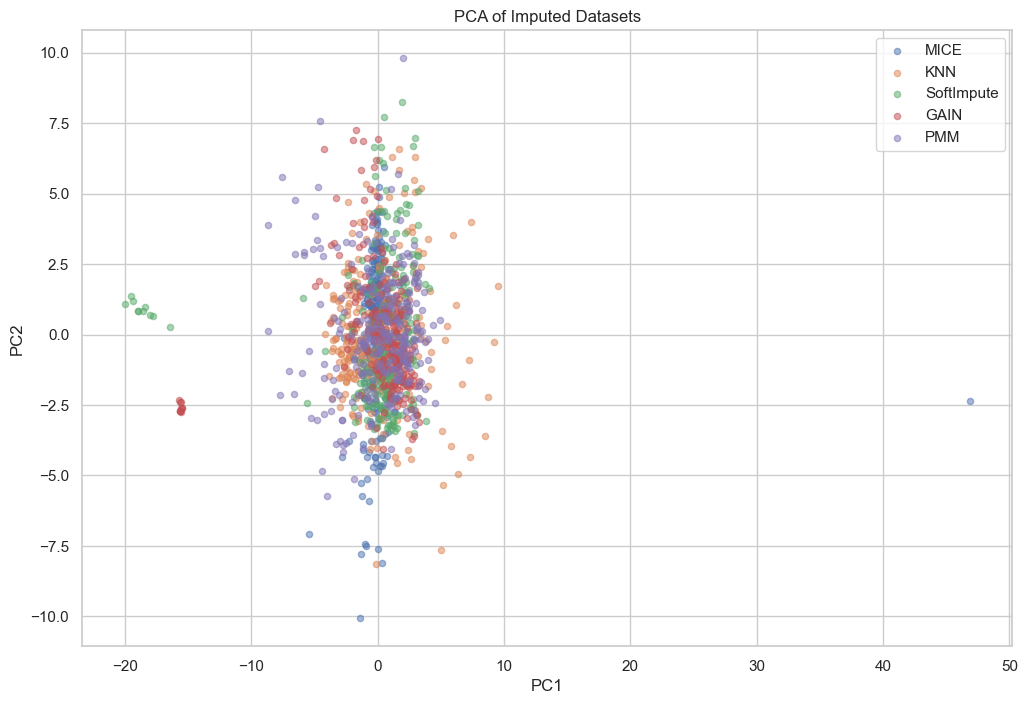

In [5]:
pca = PCA(n_components=2)
scaler = StandardScaler()

plt.figure(figsize=(12, 8))

for name, df in dfs.items():
    if name == 'Original':
        # Handle missing values for PCA in original data (drop rows or simple fill just for PCA visualization if needed)
        # Here we'll skip original for PCA if it has NaNs, or use valid rows only
        df_pca = df[numeric_cols].dropna()
    else:
        df_pca = df[numeric_cols]
    
    if len(df_pca) > 0:
        scaled_data = scaler.fit_transform(df_pca)
        components = pca.fit_transform(scaled_data)
        plt.scatter(components[:, 0], components[:, 1], label=name, alpha=0.5, s=20)

plt.title('PCA of Imputed Datasets')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## Pairwise Differences
Calculate the mean absolute difference between imputation methods to quantify similarity.

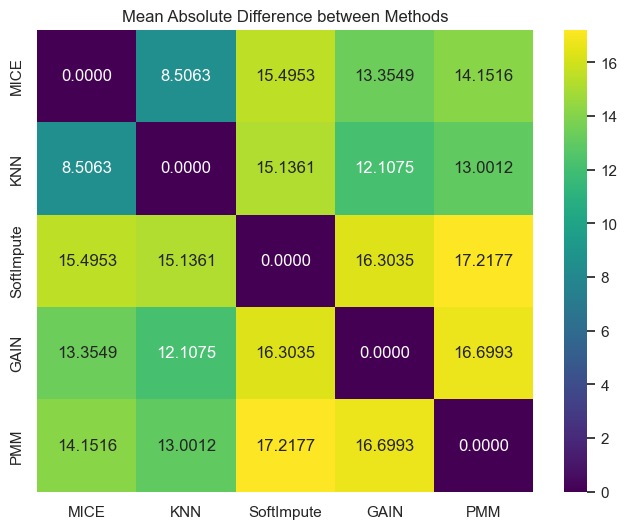

In [6]:
method_names = list(methods.keys())
method_names.remove('Original') # Compare imputation methods against each other

diff_matrix = pd.DataFrame(index=method_names, columns=method_names, dtype=float)

for m1 in method_names:
    for m2 in method_names:
        diff = np.abs(dfs[m1][numeric_cols] - dfs[m2][numeric_cols]).mean().mean()
        diff_matrix.loc[m1, m2] = diff

plt.figure(figsize=(8, 6))
sns.heatmap(diff_matrix, annot=True, cmap='viridis', fmt='.4f')
plt.title('Mean Absolute Difference between Methods')
plt.show()